## SciPy

(a) Find the k=4 nearest neighbors of mote 37 and examine whether or not the equal mean hypothesis holds for humidity data, also ensuring that all the preconditions of the respective test are valid.

(b) Repeat the above using the DFTs of the respective motes.


In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

(54, 3)
(487, 48)
Neighbors of mote 37: [39, 35, 36, 38]


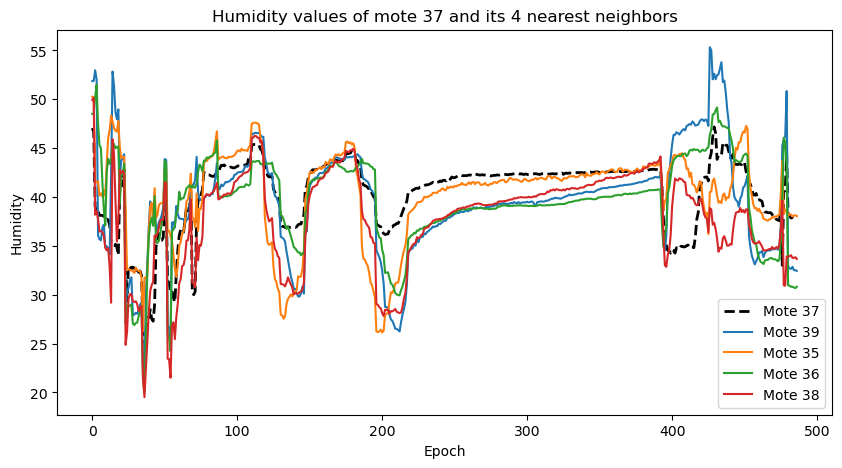

In [2]:
locs = np.loadtxt('intel_lab/mote_locs.txt')
humidity = np.loadtxt('intel_lab/humidity.txt')

print(locs.shape)
print(humidity.shape)

# Get the location of mote 37
row_37 = locs[ locs[:, 0] == 37 ]
mote37_id, mote37_x, mote37_y = row_37[0]


distances = []
for row in locs:
    mote_id, x, y = row
    if mote_id == 37:
        continue
    dist = np.linalg.norm([mote37_x - x, mote37_y - y])
    distances.append( (dist, mote_id) )

# Sort by distance
distances.sort(key=lambda d: d[0])

# The 4 nearest neighbors
neighbors_4 = distances[:4]
neighbor_ids = [int(nb[1]) for nb in neighbors_4]

print(f'Neighbors of mote 37: {neighbor_ids}')

motes_of_interest = [37] + neighbor_ids
humid_arrays = []

for mid in motes_of_interest:
    col_index = int(mid) - 1
    arr = humidity[:, col_index]  # shape (487,)
    humid_arrays.append(arr)

# Plot the humidity values (wide figure)

plt.figure(figsize=(10, 5))
for i, arr in enumerate(humid_arrays):
    if i == 0:
        plt.plot(arr, label=f'Mote {motes_of_interest[i]}', color='black', linewidth=2, linestyle='dashed')
    else:
        plt.plot(arr, label=f'Mote {motes_of_interest[i]}')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Humidity')
plt.title('Humidity values of mote 37 and its 4 nearest neighbors')
plt.show()



In [3]:
# Hypothesis testing for normality

for i, arr in enumerate(humid_arrays):
    stat, p = st.shapiro(arr)
    print(f"Mote {motes_of_interest[i]} | Shapiro p-value = {p:.3g}")
    # If p < 0.05 => fails normality


stat, p = st.f_oneway(*humid_arrays)
print("ANOVA p-value:", p)
# if p < 0.05 => we reject H0 => means differ


stat, p = st.kruskal(*humid_arrays)
print("Kruskal–Wallis p-value:", p)
# if p < 0.05 => we reject H0

Mote 37 | Shapiro p-value = 1.08e-20
Mote 39 | Shapiro p-value = 1.04e-07
Mote 35 | Shapiro p-value = 2.07e-17
Mote 36 | Shapiro p-value = 1.2e-11
Mote 38 | Shapiro p-value = 1.09e-12
ANOVA p-value: 2.615521812340235e-18
Kruskal–Wallis p-value: 1.4239104515068834e-24


In [4]:
import scipy.fft as spfft

# Compute DFT for each mote's time series (multiple "samples" per mote for a hypothesis test)

# Break into 10 segments, FFT each semgent, pick top 10 magnitude frequencies and sum them.
def segment_fft_summaries(arr, n_segments=10, top_k=10):
    seg_len = len(arr) // n_segments
    summaries = []
    start = 0
    for i in range(n_segments):
        end = start + seg_len
        if i == n_segments-1: # last segment
            end = len(arr)
        segment = arr[start:end]
        start = end

        # compute DFT using rfft 
        dft_vals = spfft.rfft(segment)
        # get magnitudes
        magnitudes = np.abs(dft_vals)
        # pick top_k largest
        top_mags = np.sort(magnitudes)[-top_k:]
        # sum
        summary = np.sum(top_mags)
        summaries.append(summary)

    return np.array(summaries)

all_mote_summaries = []
for arr in humid_arrays:
    summaries = segment_fft_summaries(arr, n_segments=10, top_k=10)
    all_mote_summaries.append(summaries)


# Check normality of each group's 10 samples
for i, motesum in enumerate(all_mote_summaries):
    mid = motes_of_interest[i]
    stat, p = st.shapiro(motesum)
    print(f"Mote {mid} DFT-based summary, Shapiro p={p:.3g}")

# If they all look normal, do ANOVA:
stat_anova, p_anova = st.f_oneway(*all_mote_summaries)
print("ANOVA p-value (DFT-based):", p_anova)

# Otherwise do Kruskal-Wallis:
stat_kruskal, p_kruskal = st.kruskal(*all_mote_summaries)
print("Kruskal–Wallis p-value (DFT-based):", p_kruskal)


Mote 37 DFT-based summary, Shapiro p=0.0273
Mote 39 DFT-based summary, Shapiro p=0.432
Mote 35 DFT-based summary, Shapiro p=0.732
Mote 36 DFT-based summary, Shapiro p=0.249
Mote 38 DFT-based summary, Shapiro p=0.299
ANOVA p-value (DFT-based): 0.5927797752113839
Kruskal–Wallis p-value (DFT-based): 0.7205286108052704
